In [1]:
# CUDA GPU checking
import torch
if torch.cuda.is_available():
    print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA GPUs are available.")

CUDA is available. Number of GPUs: 1
Device 0: NVIDIA L4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install trimesh tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.3/696.3 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.6 MB/s eta 0:00:00


In [4]:
import os

print("Current Working Directory:", os.getcwd())
os.chdir('/content/drive/MyDrive/Colab Notebooks/PotteryProject')
print("New Working Directory:", os.getcwd())

import sys
import torch
import numpy as np

import datetime
import logging
import importlib
import shutil
import argparse

from pathlib import Path
from tqdm import tqdm
from data_utils.ModelNetDataLoader import ModelNetDataLoader
from torch.utils.data import DataLoader

from dataset.pottery_dataset import PotteryDataset
from prepare.prepare import log, prepare_logger, dataset_divider

import models.pointnet_cls as PointNet
import utils.provider as provider

Current Working Directory: /content
New Working Directory: /content/drive/MyDrive/Colab Notebooks/PotteryProject


In [29]:
# BASE_DIR = os.path.dirname(os.getcwd())
# ROOT_DIR = BASE_DIR
# sys.path.append(os.path.join(ROOT_DIR, 'models'))

params = argparse.Namespace()

params.use_cpu = False
params.gpu = '1'
params.model = 'pointnet_cls'
params.num_category = 8
params.epoch = 200
params.learning_rate = 0.0001
params.num_point = 2048
params.optimizer = ''
params.decay_rate = 1e-4
params.use_normals = False
params.process_data = True
params.use_uniform_sample = False

# # initial
params.exp_name = 'pottery_demo'  # Replace with your desired experiment name
params.dataset_dir = '/content/drive/MyDrive/Colab Notebooks/PotteryProject/data/PotteryDataset_Mixed/'
params.log_dir = 'record_log'
params.log_frequency = 5 # log 5 times in total
params.scheme = "PointNet++"

# # train
# params.lr = 0.0001
params.batch_size = 4
# params.epochs = 200
# params.ckpt_path = None # checkpoint path
# params.coarse_loss = 'cd'

params.num_workers = 4

In [30]:
def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True

# '''HYPER PARAMETER'''
os.environ["CUDA_VISIBLE_DEVICES"] = params.gpu

In [31]:
def test(model, loader, num_class=40):
    mean_correct = []
    class_acc = np.zeros((num_class, 3))
    classifier = model.eval()

    for j, (_, points, target) in enumerate(loader):

        if not params.use_cpu:
            points, target = points.cuda(), target.cuda()

        points = points.transpose(2, 1)
        pred, _ = classifier(points)
        pred_choice = pred.data.max(1)[1]

        for cat in np.unique(target.cpu()):
            classacc = pred_choice[target == cat].eq(target[target == cat].long().data).cpu().sum()
            class_acc[cat, 0] += classacc.item() / float(points[target == cat].size()[0])
            class_acc[cat, 1] += 1

        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))

    class_acc[:, 2] = class_acc[:, 0] / class_acc[:, 1]
    class_acc = np.mean(class_acc[:, 2])
    instance_acc = np.mean(mean_correct)

    return instance_acc, class_acc

In [32]:
dataset_dir, val_dir, test_dir, ckpt_dir, log_fd, train_writer, val_writer = prepare_logger(params)

log(log_fd, 'Initialized.')

2024-08-08 14:20:20 ==> Initialized.


In [33]:
# dataset divide
train_file, val_file, test_file = dataset_divider(params.dataset_dir + 'all_info.csv', 0.8, dataset_dir)

print(f"Generated training dataset label file: {train_file}")
print(f"Generated val dataset label file: {val_file}")
print(f"Generated testing dataset label file: {test_file}")

# create and load Train Dataset
train_dataset = PotteryDataset(params.dataset_dir, train_file, False)
train_dataloader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True, num_workers=params.num_workers)

# create and load Val Dataset
val_dataset = PotteryDataset(params.dataset_dir, val_file, False)
val_dataloader = DataLoader(val_dataset, batch_size=params.batch_size, shuffle=False, num_workers=params.num_workers)

# create and load Test Dataset
test_dataset = PotteryDataset(params.dataset_dir, test_file, False)
test_dataloader = DataLoader(test_dataset, batch_size=params.batch_size, shuffle=False, num_workers=params.num_workers)

log(log_fd, 'Dataset loaded.')

Generated training dataset label file: record_log/pottery_demo_PointNet++_20240808142020/dataset/train_labels.csv
Generated val dataset label file: record_log/pottery_demo_PointNet++_20240808142020/dataset/val_labels.csv
Generated testing dataset label file: record_log/pottery_demo_PointNet++_20240808142020/dataset/test_labels.csv
2024-08-08 14:20:23 ==> Dataset loaded.


In [34]:
# data format checking
num_batches_train = 1

for i, data in enumerate(train_dataloader):
    if i >= num_batches_train:
        break

    broken_points, complete_points, label = data

    print(broken_points.shape)
    print(complete_points.shape)
    print(label)

torch.Size([4, 2048, 3])
torch.Size([4, 2048, 3])
tensor([0, 5, 7, 0], dtype=torch.int32)


In [35]:
# '''MODEL LOADING'''
num_class = params.num_category

classifier = PointNet.get_model(num_class, normal_channel=params.use_normals)
classifier.apply(inplace_relu)
criterion = PointNet.get_loss()

if not params.use_cpu:
    classifier = classifier.cuda()
    criterion = criterion.cuda()

try:
    checkpoint = torch.load(ckpt_dir + '/best_model.pth')
    start_epoch = checkpoint['epoch']
    classifier.load_state_dict(checkpoint['model_state_dict'])
    log(log_fd, 'Use pretrain model')
except:
    log(log_fd, 'No existing model, starting training from scratch...')
    start_epoch = 0

if params.optimizer == 'Adam':
    optimizer = torch.optim.Adam(
        classifier.parameters(),
        lr=params.learning_rate,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=params.decay_rate
    )
else:
    optimizer = torch.optim.SGD(classifier.parameters(), lr=params.learning_rate, momentum=0.95)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

train_step, val_step = 0, 0
best_instance_acc = 0.0
best_class_acc = 0.0

2024-08-08 14:20:31 ==> No existing model, starting training from scratch...


In [36]:
# training
log(log_fd, 'Start training...')
for epoch in range(start_epoch, params.epoch):
    mean_correct = []
    classifier = classifier.train()

    scheduler.step()
    for batch_id, (_, points, target) in enumerate(train_dataloader, 0):
        optimizer.zero_grad()

        points = points.data.numpy()
        # points = provider.random_point_dropout(points)
        # points[:, :, 0:3] = provider.random_scale_point_cloud(points[:, :, 0:3])
        # points[:, :, 0:3] = provider.shift_point_cloud(points[:, :, 0:3])
        points = torch.Tensor(points)
        points = points.transpose(2, 1)

        if not params.use_cpu:
            points, target = points.cuda(), target.cuda()

        pred, trans_feat = classifier(points)
        loss = criterion(pred, target.long(), trans_feat)
        pred_choice = pred.data.max(1)[1]

        correct = pred_choice.eq(target.long().data).cpu().sum()
        mean_correct.append(correct.item() / float(points.size()[0]))

        loss.backward()
        optimizer.step()
        train_step += 1

    train_instance_acc = np.mean(mean_correct)
    log(log_fd, "Train Epoch [{:03d}/{:03d}]: Train Instance Accuracy = {:.6f}".format(epoch, params.epoch, train_instance_acc))

    with torch.no_grad():
        instance_acc, class_acc = test(classifier.eval(), val_dataloader, num_class=num_class)

        if (instance_acc >= best_instance_acc):
            best_instance_acc = instance_acc
            best_epoch = epoch + 1

        if (class_acc >= best_class_acc):
            best_class_acc = class_acc
        log(log_fd, 'Test Instance Accuracy: %f, Class Accuracy: %f' % (instance_acc, class_acc))
        log(log_fd, 'Best Instance Accuracy: %f, Class Accuracy: %f' % (best_instance_acc, best_class_acc))

        if (instance_acc >= best_instance_acc):
            log(log_fd, 'Save model...')
            savepath = str(ckpt_dir) + '/best_model.pth'
            log(log_fd, 'Saving at %s' % savepath)
            state = {
                'epoch': best_epoch,
                'instance_acc': instance_acc,
                'class_acc': class_acc,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }
            torch.save(state, savepath)

        val_step += 1

log(log_fd, 'End of training...')

2024-08-08 14:20:35 ==> Start training...
2024-08-08 14:20:39 ==> Train Epoch [000/200]: Train Instance Accuracy = 0.251923
2024-08-08 14:20:39 ==> Test Instance Accuracy: 0.279412, Class Accuracy: 0.214062
2024-08-08 14:20:39 ==> Best Instance Accuracy: 0.279412, Class Accuracy: 0.214062
2024-08-08 14:20:39 ==> Save model...
2024-08-08 14:20:39 ==> Saving at record_log/pottery_demo_PointNet++_20240808142020/checkpoint/best_model.pth
2024-08-08 14:20:43 ==> Train Epoch [001/200]: Train Instance Accuracy = 0.319231
2024-08-08 14:20:44 ==> Test Instance Accuracy: 0.308824, Class Accuracy: 0.200521
2024-08-08 14:20:44 ==> Best Instance Accuracy: 0.308824, Class Accuracy: 0.214062
2024-08-08 14:20:44 ==> Save model...
2024-08-08 14:20:44 ==> Saving at record_log/pottery_demo_PointNet++_20240808142020/checkpoint/best_model.pth
2024-08-08 14:20:48 ==> Train Epoch [002/200]: Train Instance Accuracy = 0.294231
2024-08-08 14:20:48 ==> Test Instance Accuracy: 0.323529, Class Accuracy: 0.250521
2

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

In [38]:
# test
classifier = classifier.eval()
all_preds = []
all_targets = []
all_preds_proba = []

for j, (_, points, target) in enumerate(test_dataloader):

    if not params.use_cpu:
        points, target = points.cuda(), target.cuda()

    points = points.transpose(2, 1)
    pred, _ = classifier(points)

    pred_proba = torch.nn.functional.softmax(pred, dim=1)
    pred_choice = pred.data.max(1)[1]

    all_preds.append(pred_choice.cpu().numpy())
    all_targets.append(target.cpu().numpy())
    all_preds_proba.append(pred_proba.cpu().detach().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
all_preds_proba = np.concatenate(all_preds_proba)

In [39]:
# accuracy
accuracy = accuracy_score(all_targets, all_preds)
# precision
precision = precision_score(all_targets, all_preds, average='weighted')
# recall
recall = recall_score(all_targets, all_preds, average='weighted')
# f1 score
f1 = f1_score(all_targets, all_preds, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6811594202898551
Precision: 0.7219921785139176
Recall: 0.6811594202898551
F1 Score: 0.6771700642133847


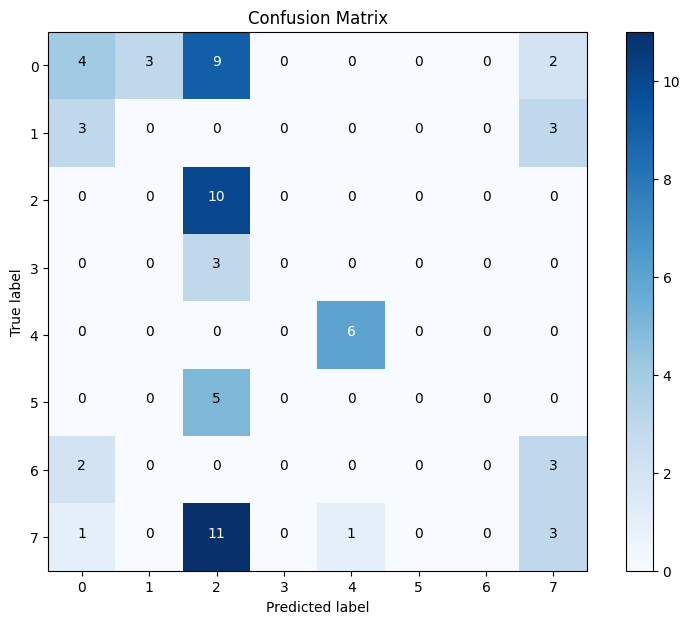

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = np.unique(all_targets)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.show()

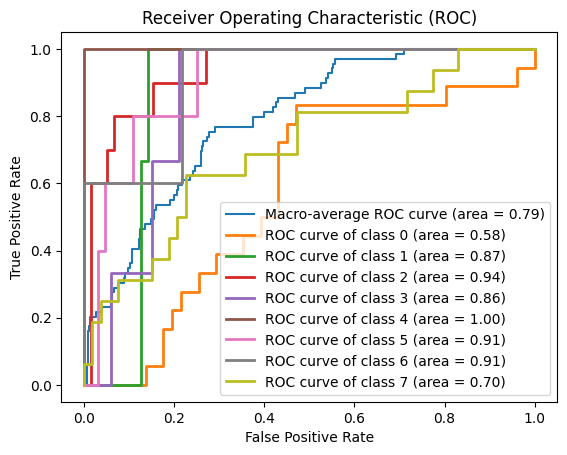

In [27]:
# ROC Curve (Receiver Operating Characteristic Curve)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = len(np.unique(all_targets))
y_bin = label_binarize(all_targets, classes=np.arange(n_classes))
y_score = np.array(all_preds_proba)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["macro"], tpr["macro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# display curve
plt.figure()
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {:.2f})'.format(roc_auc["macro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {} (area = {:.2f})'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()


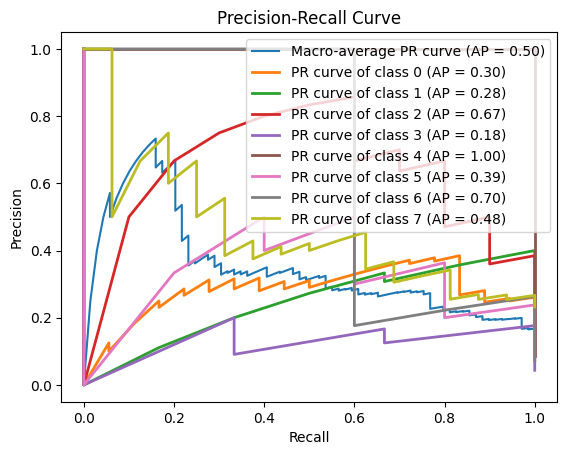

In [28]:
# Precision-Recall Curve
n_classes = len(np.unique(all_targets))
y_bin = label_binarize(all_targets, classes=np.arange(n_classes))
y_score = all_preds_proba

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])

precision["macro"], recall["macro"], _ = precision_recall_curve(y_bin.ravel(), y_score.ravel())
average_precision["macro"] = average_precision_score(y_bin, y_score, average="macro")

# display curve
plt.figure()
plt.plot(recall["macro"], precision["macro"], label='Macro-average PR curve (AP = {:.2f})'.format(average_precision["macro"]))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='PR curve of class {} (AP = {:.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()